# Part 2: Introduction to REINVENT

REINVENT is a generative model for molecules. Specifically, it is a SMILES-based generative model: it learns to write SMILES strings that correspond to valid, drug-like molecules. REINVENT starts from a model called the **prior**. The prior has been trained on lots of known, drug-like chemistry, so it already knows how to generate reasonable molecules (not just random junk). For optimization, we make a copy of the prior called the **agent**. The prior stays frozen as a reference for what “normal chemistry” looks like. The agent is the one we train. The whole point of REINVENT is to update the agent so it no longer just samples generic prior-like molecules, but instead starts generating molecules that match our design goals.

---

## How REINVENT learns

REINVENT uses reinforcement learning (RL) to steer the agent. Each RL step works like this:  
1. The agent samples a batch of SMILES (candidate molecules).  
2. Each SMILES is scored using our scoring function.  
3. The agent is updated so that high-scoring molecules become more likely next time, and low-scoring molecules become less likely.

This means the agent is literally being pushed toward “make more things like these good ones.” Over time, the distribution of molecules it generates moves toward the chemical space we’re asking for.

---

## Flavours of REINVENT

There are a few related models built on the same idea, but targeted at slightly different design problems:

- **REINVENT (what we're using here)**  
  - Generates complete molecules as SMILES from scratch.  
  - Can be steered toward arbitrary objectives (logP, QED, etc).  
  - Good for “give me novel drug-like molecules.”

- **LibINVENT**  
  - Generates virtual libraries around a common scaffold or core.  
  - You fix the core, and it proposes R-group decorations / substitutions.  
  - Good for “enumerate medicinal chemistry ideas around this series.”

- **LinkINVENT**  
  - Generates linkers between two fragments.  
  - Think: you have fragment A and fragment B bound in a pocket and you want a linker that connects them.  
  - Good for fragment linking / PROTAC linker design / bridging warheads.

- **Mol2Mol**  
  - Takes an input molecule and proposes a new related molecule.  
  - More like “transform this” than “generate from nothing.”  
  - Good for scaffold hopping, analogue generation, and lead optimization.

They all share the same high-level loop — generate candidate → score it → learn to make better ones — but differ in what exactly is being generated (full molecule vs decoration vs linker vs modified version of an input).

---

## Scoring functions

The scoring function is how we tell REINVENT what “good” means. We define it in a TOML file (for example in `config/slogp_max.toml` or `config/druglike.toml`) as a set of scoring components. Typical components include:
- logP (lipophilicity)
- molecular weight
- H-bond donors / H-bond acceptors
- TPSA (polarity / permeability)
- QED (drug-likeness)
- synthetic accessibility

For each component, REINVENT does two things:
1. It calculates the raw property of the molecule (for example “TPSA = 74 Å²” or “HBD = 1”).
2. It transforms that property into a desirability score between 0 and 1. That transform can mean “higher is better,” “lower is better,” or “a middle range is best.”

All component scores are then combined into a single final score called `Score`. That final `Score` is used as the reward for RL. In other words: the agent is trained to generate SMILES with a high `Score`.

---

## What we will do

1. **Understand the structure of the `.toml` files**

2. **Run `config/slogp_max.toml`**  
   We ask REINVENT to generate molecules with high logP. This is a simple, single-objective case so you can clearly see that the model can be pushed in a specific direction.

3. **Visualise the slogp_max results**  
   REINVENT writes a CSV (`output/run_1.csv`) that includes:
   - the generated SMILES,
   - each property score (both raw values and transformed 0–1 values),
   - the final `Score`,
   - and which RL step it came from.
   
   We will:
   - plot how the average score changes over RL steps,
   - and visualise example molecules from different stages of training,
     so you can literally see the chemistry shift toward higher logP.

4. **Run `config/druglike.toml`**  
   We ask REINVENT to generate molecules that look more generally drug-like. This version balances multiple properties at once (size, polarity, H-bonding, etc.) instead of just chasing one thing.

5. **Visualise the druglike results**  
   Similar to step 3, we will:
   - plot how the average scores change over RL steps for the druglike run,
   - and visualise example molecules from different stages of training,
     so you can see how the chemistry balances multiple objectives.

6. **Try your own configurations**  
   Create and experiment with custom TOML configuration files to optimize for different property combinations.

In [ ]:
# Import all required libraries
from pathlib import Path
import subprocess
import shlex
import os
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw

## 1. Open and get familiar with the structure of the `.toml` files!



In [ ]:
# For reading TOML files
try:
    import tomllib  # Python 3.11+
except ImportError:
    import tomli as tomllib  # For older Python versions

# Load the simpler slogp_max.toml as an example
with open("config/slogp_max.toml", "rb") as f:
    slogp_config = tomllib.load(f)

print("=" * 60)
print("slogp_max.toml structure:")
print("=" * 60)
print()

# 1. Top-level settings
print("1. TOP-LEVEL SETTINGS:")
print(f"   run_type: {slogp_config['run_type']}")
print(f"   device: {slogp_config['device']}")
print(f"   tb_logdir: {slogp_config['tb_logdir']}")
print()

# 2. Parameters
print("2. PARAMETERS [parameters]:")
params = slogp_config['parameters']
print(f"   agent_file: {params['agent_file']}")
print(f"   prior_file: {params['prior_file']}")
print(f"   batch_size: {params['batch_size']}")
print(f"   randomize_smiles: {params['randomize_smiles']}")
print()

# 3. Learning strategy
print("3. LEARNING STRATEGY [learning_strategy]:")
learning = slogp_config['learning_strategy']
print(f"   type: {learning['type']}")
print(f"   sigma: {learning['sigma']}")
print(f"   rate (learning rate): {learning['rate']}")
print()

# 4. Stage configuration
print("4. STAGE CONFIGURATION [[stage]]:")
stage = slogp_config['stage'][0]  # First stage
print(f"   max_steps: {stage['max_steps']}")
print(f"   termination: {stage['termination']}")
print(f"   chkpt_file: {stage['chkpt_file']}")
print()

# 5. Scoring function
print("5. SCORING FUNCTION [stage.scoring]:")
scoring = stage['scoring']
print(f"   type: {scoring['type']} (how component scores are combined)")
print()

# 6. Scoring components
print("6. SCORING COMPONENTS [[stage.scoring.component]]:")
components = scoring['component']
for i, comp in enumerate(components, 1):
    # Each component has a property type (e.g., SlogP, MolecularWeight)
    prop_type = list(comp.keys())[0]  # Get the property name
    prop_config = comp[prop_type]
    endpoint = prop_config['endpoint'][0]
    
    print(f"   Component {i}: {prop_type}")
    print(f"      - name: {endpoint['name']}")
    print(f"      - weight: {endpoint['weight']}")
    
    transform = endpoint['transform']
    print(f"      - transform: {transform['type']}")
    if transform['type'] == 'sigmoid':
        print(f"        (low={transform['low']}, high={transform['high']}, k={transform['k']})")
        print(f"        → Rewards HIGHER values in the range")
    elif transform['type'] == 'reverse_sigmoid':
        print(f"        (low={transform['low']}, high={transform['high']}, k={transform['k']})")
        print(f"        → Rewards LOWER values in the range")
    elif transform['type'] == 'double_sigmoid':
        print(f"        (low={transform['low']}, high={transform['high']})")
        print(f"        → Rewards values INSIDE the range [low, high]")
    print()

print("=" * 60)
print("KEY CONCEPT:")
print("=" * 60)
print("Each component: raw property → transform to [0,1] → weight → combine → final Score")
print("The final Score is used as the reward signal for reinforcement learning.")


Now let's look at the more complex `druglike.toml` configuration, which uses multiple scoring components:


In [ ]:
# For reading TOML files
try:
    import tomllib  # Python 3.11+
except ImportError:
    import tomli as tomllib  # For older Python versions

# Load the druglike.toml configuration
with open("config/druglike.toml", "rb") as f:
    druglike_config = tomllib.load(f)

print("=" * 60)
print("druglike.toml - Multi-objective scoring function")
print("=" * 60)
print()

stage = druglike_config['stage'][0]
scoring = stage['scoring']
components = scoring['component']

print(f"Scoring type: {scoring['type']}")
print(f"  → {scoring['type']} means: if ANY component is ~0, the whole score drops.")
print(f"  → This rewards BALANCED drug-like profiles, not extreme single properties.")
print()
print(f"Number of scoring components: {len(components)}")
print()

print("Components:")
for i, comp in enumerate(components, 1):
    prop_type = list(comp.keys())[0]
    prop_config = comp[prop_type]
    endpoint = prop_config['endpoint'][0]
    transform = endpoint['transform']
    
    print(f"{i}. {endpoint['name']} (weight={endpoint['weight']})")
    print(f"   Property: {prop_type}")
    print(f"   Transform: {transform['type']}")
    
    if transform['type'] == 'double_sigmoid':
        print(f"   → Rewards values in range [{transform['low']}, {transform['high']}]")
    elif transform['type'] == 'sigmoid':
        print(f"   → Rewards values ≥ {transform['low']} (up to {transform['high']})")
    elif transform['type'] == 'reverse_sigmoid':
        print(f"   → Rewards values ≤ {transform['high']} (penalizes above {transform['high']})")
    print()

# Check for diversity filter
if 'diversity_filter' in druglike_config:
    df = druglike_config['diversity_filter']
    print("=" * 60)
    print("DIVERSITY FILTER:")
    print("=" * 60)
    print(f"Type: {df['type']}")
    print(f"Purpose: Prevents the model from spamming one chemotype")
    print(f"  - Groups molecules by Murcko scaffold")
    print(f"  - Limits high-scoring molecules per scaffold to {df['bucket_size']}")
    print(f"  - Applies penalty multiplier {df['penalty_multiplier']} for overused scaffolds")
    print()


## 2. Run `config/slogp_max.toml`

In [10]:
# RUN SLOG_P
# Prepare paths
config_path = Path("config/slogp_max.toml").resolve()
prior_path = Path("priors/reinvent.prior").resolve()
log_path = Path("output/slogp_max.log").resolve()

# Make sure output dir exists
Path("output").mkdir(exist_ok=True)

# Verify required files exist
assert config_path.exists(), f"Missing {config_path}"
assert prior_path.exists(), f"Missing {prior_path}"

# Run REINVENT in background
cmd = f"reinvent -l {log_path.as_posix()} {config_path.as_posix()}"
print("Launching REINVENT:", cmd)

reinvent_proc = subprocess.Popen(
    shlex.split(cmd),
    stdout=subprocess.DEVNULL,
    stderr=subprocess.STDOUT,
    text=True
)

print("REINVENT running with PID:", reinvent_proc.pid)
print("\n💡 Check output/logs:")
print(f"   - Log file: {log_path}")
print(f"   - Results CSV: output/run_1.csv (created after training completes)")
print(f"   - Check progress: tail -f {log_path}")


Launching REINVENT: reinvent -l /home/teaching/dtc-struc-bio-smolecules/output/slogp_max.log /home/teaching/dtc-struc-bio-smolecules/config/slogp_max.toml
REINVENT running with PID: 15192

💡 Check output/logs:
   - Log file: /home/teaching/dtc-struc-bio-smolecules/output/slogp_max.log
   - Results CSV: output/druglike_1.csv (created after training completes)
   - Check progress: tail -f /home/teaching/dtc-struc-bio-smolecules/output/slogp_max.log


## 3. Visualise the slogp_max results


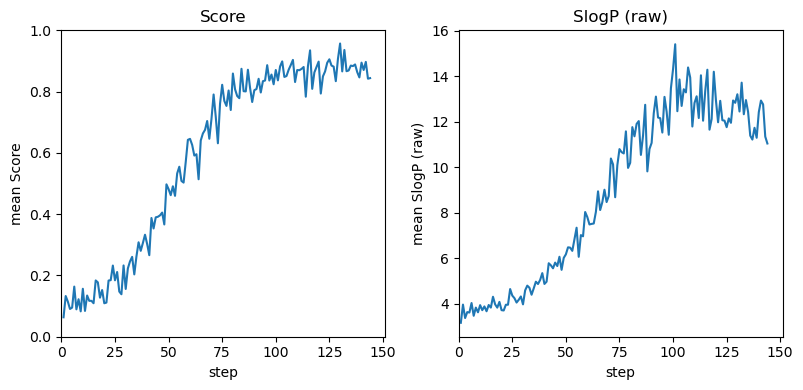

In [19]:
SHOW_RAW = True  # True = plot "... (raw)" columns, False = plot transformed columns

# load + keep valid molecules only once
df = pd.read_csv("output/run_1.csv")
df = df[df["SMILES_state"] == 1].copy()

# figure out which metric columns to plot
if SHOW_RAW:
    metric_cols = [c for c in df.columns if c.endswith("(raw)")]
else:
    raw_pairs = [(c, c.replace(" (raw)", "")) for c in df.columns if c.endswith("(raw)")]
    metric_cols = [t for _, t in raw_pairs if t in df.columns]

# always include Score first
plot_cols = ["Score"] + [c for c in metric_cols if c != "Score"]

# compute per-step means for each column once
step_means = {}
for col in plot_cols:
    tmp_col = pd.to_numeric(df[col], errors="coerce")
    step_means[col] = (
        pd.DataFrame({"step": df["step"], col: tmp_col})
        .groupby("step", as_index=False)[col]
        .mean()
        .sort_values("step")
    )

# make grid with 3 columns per row
n = len(plot_cols)
cols_per_row = 3
rows = math.ceil(n / cols_per_row)

plt.figure(figsize=(12, 4*rows))
for i, col in enumerate(plot_cols, start=1):
    ax = plt.subplot(rows, cols_per_row, i)
    ax.plot(step_means[col]["step"], step_means[col][col])
    ax.set_xlabel("step")
    ax.set_ylabel(f"mean {col}")
    ax.set_title(col)
    ax.set_xlim(left=0)
    if (col == "Score") or (not SHOW_RAW):
        ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


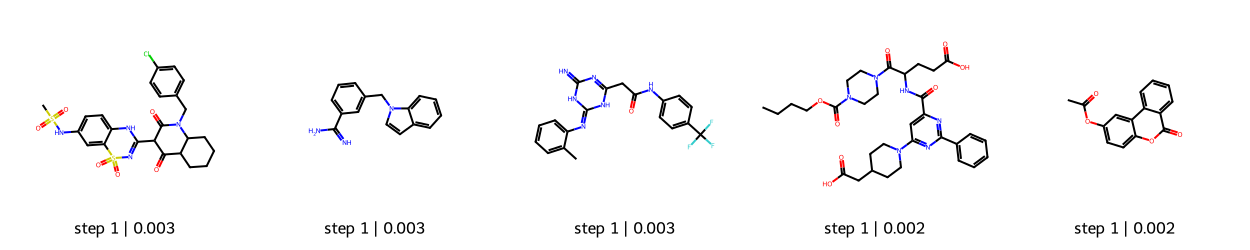

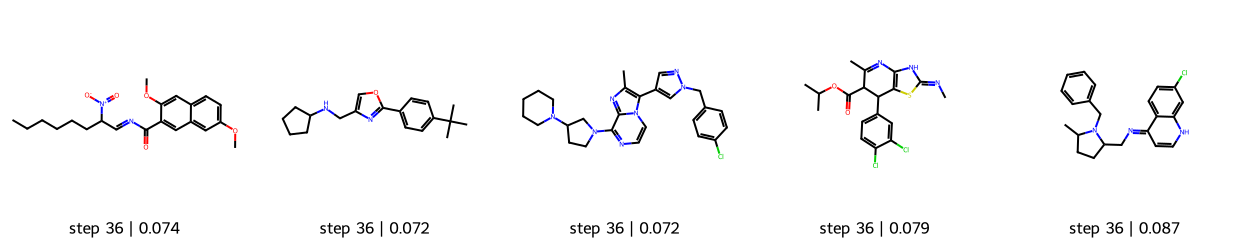

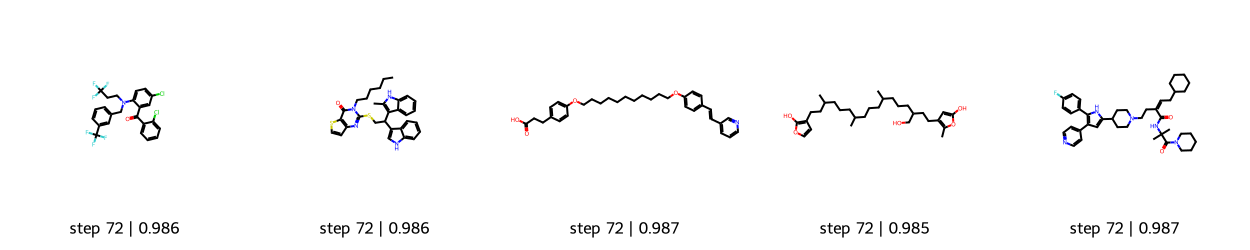

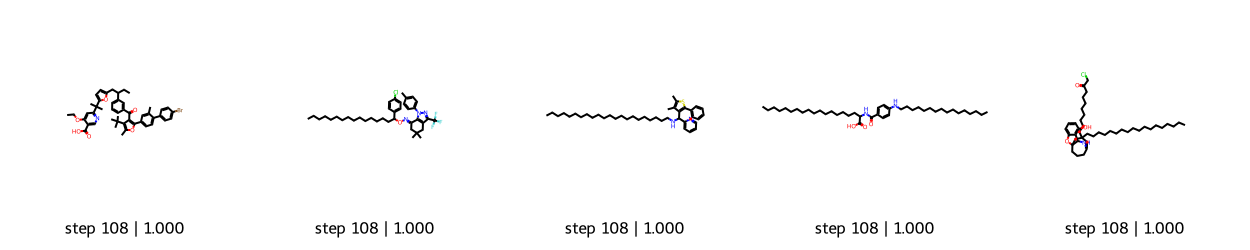

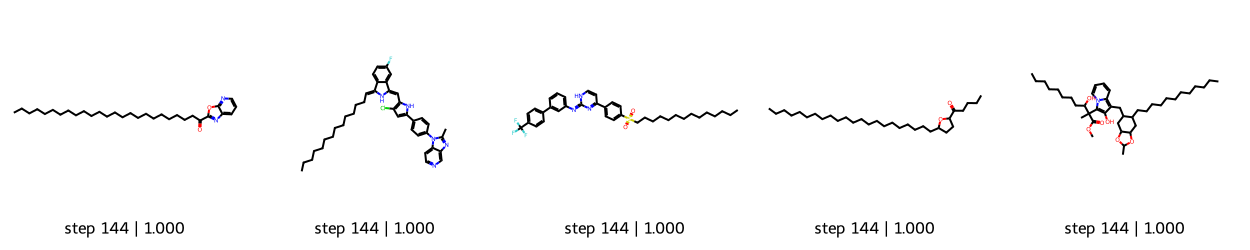

In [20]:
steps = sorted(df["step"].unique())
picked = sorted({steps[i] for i in np.linspace(0, len(steps)-1, 5).astype(int)})

for step in picked:
    sub = df[df["step"] == step].copy()
    med = sub["Score"].median()
    sub["dist"] = (sub["Score"] - med).abs()
    mid5 = sub.sort_values("dist").head(5)
    mols = [Chem.MolFromSmiles(s) for s in mid5["SMILES"]]
    legends = [f"step {step} | {x:.3f}" for x in mid5["Score"]]
    display(Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(250,250), legends=legends))


We can push Reinvent4 to generate molecules with higher predicted logP, but be aware of predictable failure modes. The model will often produce long, “stringy” hydrophobic molecules (e.g., extended alkyl chains or extra aromatic rings) because increasing non-polar surface area and removing polar/ionizable groups is an easy way to raise predicted logP. Those molecules can be valid chemically but are frequently useless for real applications. The RL agent has effectively exploited a single numeric reward. 

To avoid this, you could combine the logP objective with constraints or complementary metrics (synthetic accessibility, molecular weight, QED, polar surface area, substructure filters) and consider using multiple logP predictors or experimentally validated data to reduce reward-hacking. You'll explore this later on.

## 4. Run `config/druglike.toml`

In [21]:
# Prepare paths
config_path = Path("config/druglike.toml").resolve()
prior_path = Path("priors/reinvent.prior").resolve()
log_path = Path("output/druglike.log").resolve()

# Make sure output dir exists
Path("output").mkdir(exist_ok=True)

# Verify required files exist
assert config_path.exists(), f"Missing {config_path}"
assert prior_path.exists(), f"Missing {prior_path}"

# Run REINVENT in background
cmd = f"reinvent -l {log_path.as_posix()} {config_path.as_posix()}"
print("Launching REINVENT:", cmd)

reinvent_proc = subprocess.Popen(
    shlex.split(cmd),
    stdout=subprocess.DEVNULL,
    stderr=subprocess.STDOUT,
    text=True
)

print("REINVENT running with PID:", reinvent_proc.pid)
print("\n💡 Check output/logs:")
print(f"   - Log file: {log_path}")
print(f"   - Results CSV: output/druglike_1.csv (created after training completes)")
print(f"   - Check progress: tail -f {log_path}")


Launching REINVENT: reinvent -l /home/teaching/dtc-struc-bio-smolecules/output/druglike.log /home/teaching/dtc-struc-bio-smolecules/config/druglike.toml
REINVENT running with PID: 15408

💡 Check output/logs:
   - Log file: /home/teaching/dtc-struc-bio-smolecules/output/druglike.log
   - Results CSV: output/druglike_1.csv (created after training completes)
   - Check progress: tail -f /home/teaching/dtc-struc-bio-smolecules/output/druglike.log


## 5. Visualise the druglike results


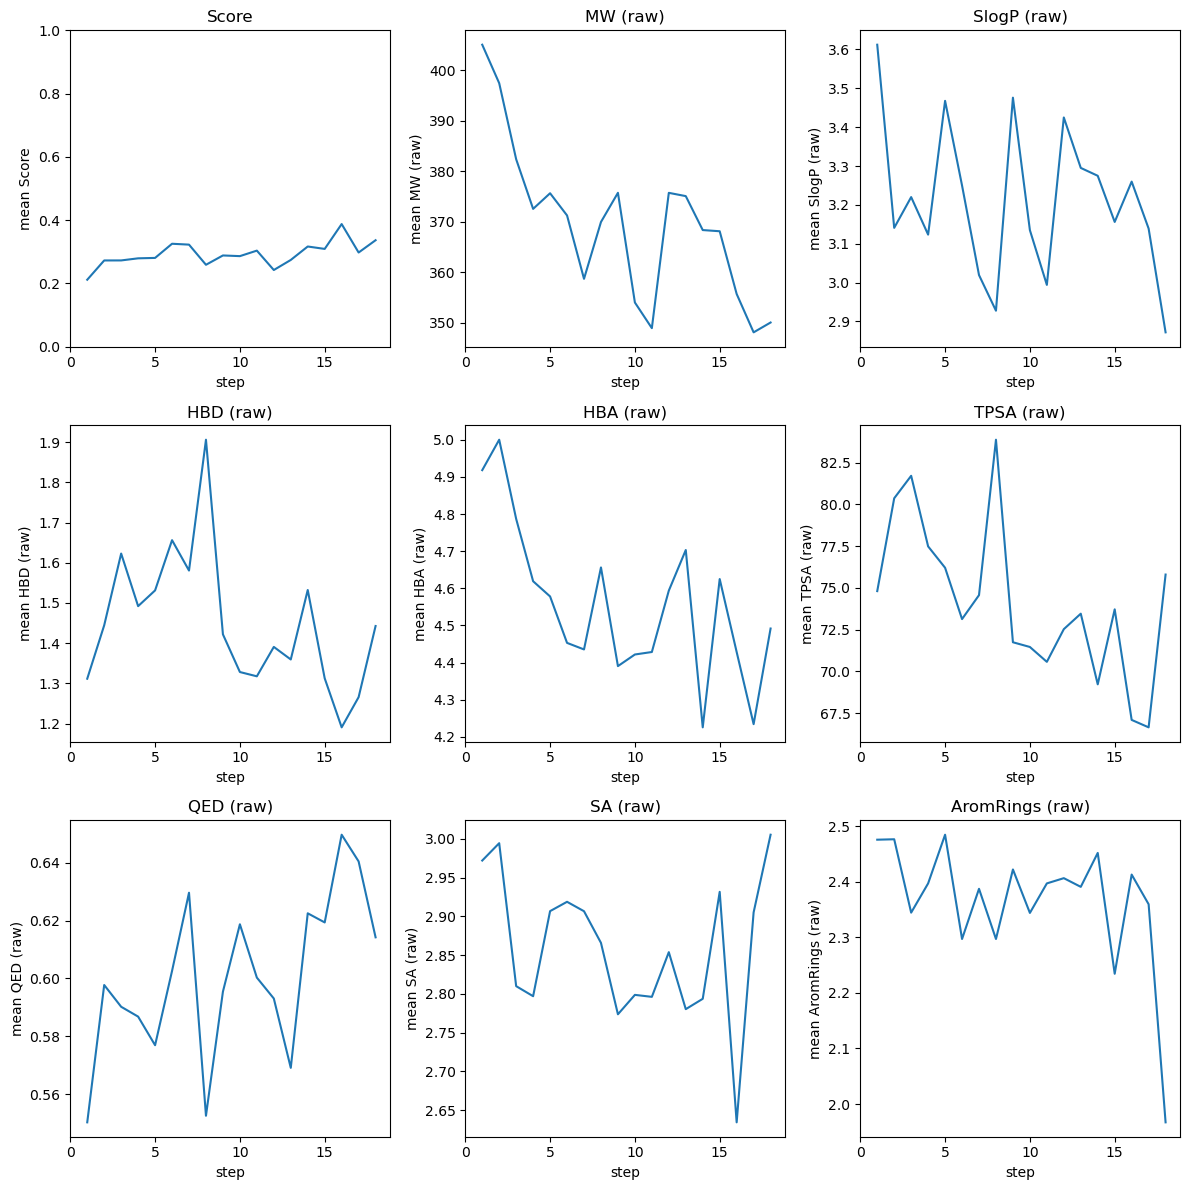

In [22]:
SHOW_RAW = True  # True = plot "... (raw)" columns, False = plot transformed columns

# load + keep valid molecules only once
df = pd.read_csv("output/druglike_1.csv")
df = df[df["SMILES_state"] == 1].copy()

# figure out which metric columns to plot
if SHOW_RAW:
    metric_cols = [c for c in df.columns if c.endswith("(raw)")]
else:
    raw_pairs = [(c, c.replace(" (raw)", "")) for c in df.columns if c.endswith("(raw)")]
    metric_cols = [t for _, t in raw_pairs if t in df.columns]

# always include Score first
plot_cols = ["Score"] + [c for c in metric_cols if c != "Score"]

# compute per-step means for each column once
step_means = {}
for col in plot_cols:
    tmp_col = pd.to_numeric(df[col], errors="coerce")
    step_means[col] = (
        pd.DataFrame({"step": df["step"], col: tmp_col})
        .groupby("step", as_index=False)[col]
        .mean()
        .sort_values("step")
    )

# make grid with 3 columns per row
n = len(plot_cols)
cols_per_row = 3
rows = math.ceil(n / cols_per_row)

plt.figure(figsize=(12, 4*rows))
for i, col in enumerate(plot_cols, start=1):
    ax = plt.subplot(rows, cols_per_row, i)
    ax.plot(step_means[col]["step"], step_means[col][col])
    ax.set_xlabel("step")
    ax.set_ylabel(f"mean {col}")
    ax.set_title(col)
    ax.set_xlim(left=0)
    if (col == "Score") or (not SHOW_RAW):
        ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


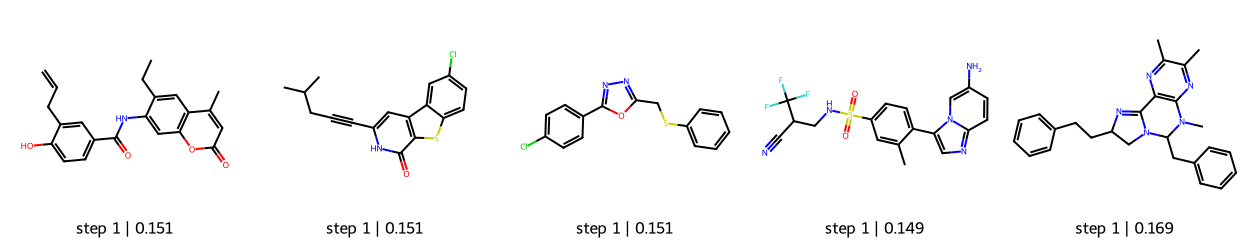

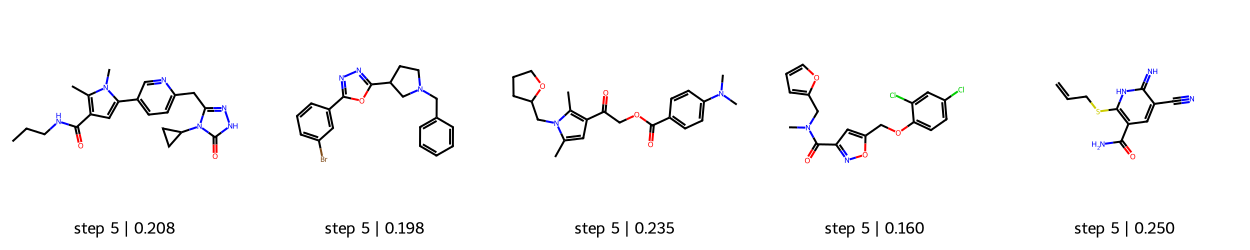

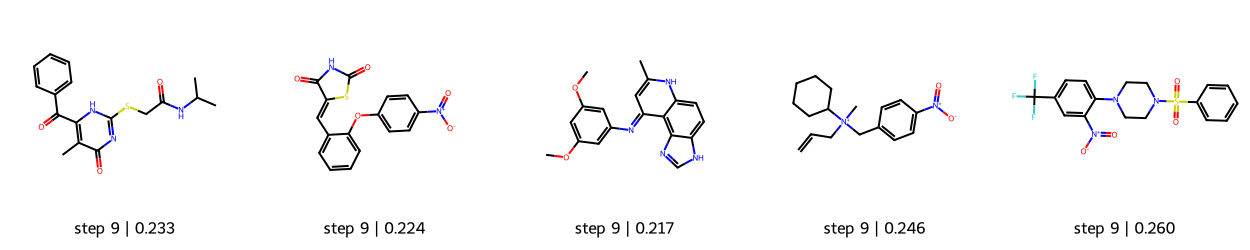

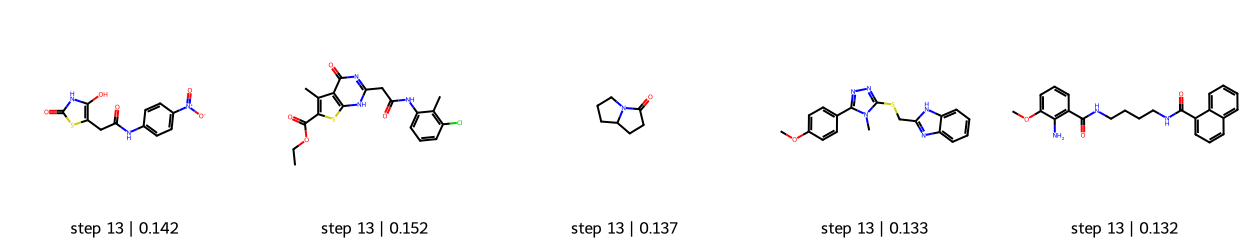

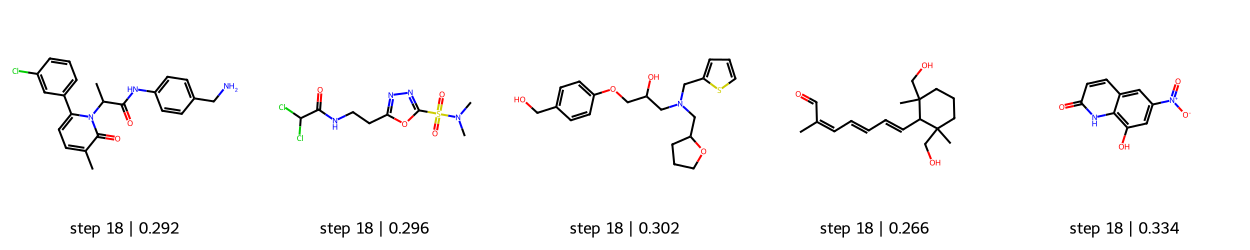

In [23]:
steps = sorted(df["step"].unique())
picked = sorted({steps[i] for i in np.linspace(0, len(steps)-1, 5).astype(int)})

for step in picked:
    sub = df[df["step"] == step].copy()
    med = sub["Score"].median()
    sub["dist"] = (sub["Score"] - med).abs()
    mid5 = sub.sort_values("dist").head(5)
    mols = [Chem.MolFromSmiles(s) for s in mid5["SMILES"]]
    legends = [f"step {step} | {x:.3f}" for x in mid5["Score"]]
    display(Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(250,250), legends=legends))


## Try your own configurations

Now that you've seen how REINVENT works, try creating your own TOML configuration files and running them. Here are some ideas:

### Task 1: Modify druglike.toml
Try adjusting the weights or target ranges in `config/druglike.toml` to prioritize different properties.


In [ ]:
# Your code here for Task 1


### Task 2: Create a new TOML configuration
Create a custom TOML file that optimizes for specific properties relevant to your target (e.g., lower molecular weight, specific logP range, higher QED).


In [ ]:
# Your code here for Task 2


### Task 3: Improve `slogp_max.toml` by reducing the 'stringy' molecules generated. 
Try different reward formulas to combine logP with penalties (e.g., `score = w1 * normalized_logP - w2 * MW_penalty - w3 * SA_penalty + w4 * QED`).

In [17]:
# Your code here for Task 3
